In [1]:
import os
import json
from pathlib import Path
import openai
import pandas as pd
import logging
from IPython.display import clear_output
from copy import deepcopy
import networkx as nx
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

from parse import parse

from finetuning import prepare_data
from utils.graph import create_interview_flowchart, create_interview_flowchart2
from utils.utils import path_to_finetuning_data_folder, prepare_kshot_prompt_using_levenshtein_distance
from nodes.node_functions import *

In [6]:
from datetime import datetime

In [10]:
from utils.models_metadata import get_model_metadata, add_new_model

# -1: playground

# 0: setup

In [71]:
# create_models_metadata()

In [2]:
# prepare_data.prepare_formatted_finetuning_dataset(model_name = "ask_how_it_works", model_version = "4.1.23")

# prepare_data.prepare_formatted_finetuning_dataset(model_name = "validate_answer_how_it_works", model_version = "4.1.23")

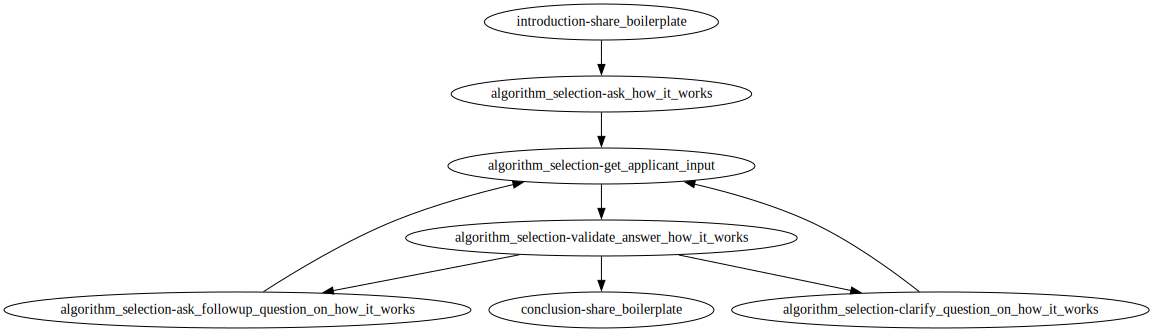

In [2]:
interview_flowchart, interview_flowchart_visual = create_interview_flowchart()
# interview_flowchart, interview_flowchart_visual = create_interview_flowchart2()

interview_flowchart_visual

In [3]:
# chat

# each list within this variable is the conversation in a particular section. each string within that list is the ordered dialogue from each member of the interview
chat_history_by_section = [[]]
chat_history_by_line = []
flattened_chat_history = ""

# list of strings.
# each string is the summary of that section
chat_section_summaries = []

# list of tuples containing the model called, the prompt, and the completion
prompt_and_completions_so_far = []

# list of the nodes that have been visited till the current point
nodes_visited_names = []
previous_node_section_name = None
current_node_name = "introduction-share_boilerplate"
current_node_section_name = "introduction"

is_interview_complete = False

carryover_data = dict(algorithm_selection=dict(subject='autoencoder'))

In [7]:
# current_node_name = "algorithm_selection-ask_how_it_works"

# current_node = interview_flowchart.nodes[current_node_name]
    
# current_node_function_args = deepcopy(current_node['function_args'])
# current_node_function_args['carryover_data'] = carryover_data
# current_node_function_args['chat_history_by_section'] = chat_history_by_section

# current_node_output = current_node['function'](**current_node_function_args)

# 1. run

In [4]:
while not is_interview_complete:   
    # run function associated with current node. if it involves an LLM completion, get a label and add to finetuning dataset
    current_node = interview_flowchart.nodes[current_node_name]
    
    current_node_function_args = deepcopy(current_node['function_args'])
    current_node_function_args['carryover_data'] = carryover_data
    current_node_function_args['chat_history_by_section'] = chat_history_by_section
    
    current_node_output = current_node['function'](**current_node_function_args)
    
    if current_node_output['new_chat_line']:
        # store return values in appropriate variables (chat_history)
        chat_history_by_section[-1].append(current_node_output['new_chat_line'])
        chat_history_by_line.append(current_node_output['new_chat_line'])
        flattened_chat_history += "\n" + current_node_output['new_chat_line']
        clear_output()
        print(flattened_chat_history)
    
    # update nodes_visited
    nodes_visited_names.append(current_node_name)
    
    # based on output value, identify next node to visit. update current_node
    outgoing_edges = list(interview_flowchart.out_edges(current_node_name, data=True))
    if len(outgoing_edges) == 0:
        is_interview_complete = True
    else:
        edge_to_traverse = None
        if len(outgoing_edges) == 1:
            edge_to_traverse = outgoing_edges[0]
        else:
            for edge in outgoing_edges:
                if current_node_output['routing_value'] in edge[-1]['passthrough_values']:
                    edge_to_traverse = edge
        previous_node_section_name = current_node_section_name
        current_node_name = edge_to_traverse[1]
        current_node_section_name = current_node_name.split("-")[0]
                    
        # if we are in a new section (subgraph)
        if current_node_section_name != previous_node_section_name:
            # create a new list in chat_history_by_section
            chat_history_by_section.append([])
            # TODO: summarize the previous topic and add it to chat_topic_summaries
            


Interviewer: Thank you for taking the time out to interview with us. 
    In this interview, we will cover a range of topics and ask questions to assess your skill level as a Data Scientist. 
    If you don't understand a question, feel free to ask questions to get clarification.
    Let's get started.
Interviewer: Can you explain to me how an autoencoder works?
Applicant: it's a neural network.
Interviewer: Okay, those were all the topics we wanted to cover. Thank you again for taking the time out to interview with us.
    We will get back to you with our decision. Have a nice day!


In [6]:
prepare_data.validate_observations_for_finetuning_from_queue()